In [399]:
import os
os.chdir('C:/Users/acorn/Desktop')

In [400]:
import pandas as pd 
credit = pd.read_csv('credit.csv')

In [401]:
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import re
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve,accuracy_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform, randint
import lightgbm as lgb
import xgboost as xgb

In [455]:
credit.shape

(1000, 17)

In [402]:
credit.describe()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount($),Length of current employment(Month),Sex & Marital Status,Duration in Current address,Most valuable available asset,Age (years),Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.700000,2.183000,20.903000,2.54500,2.828000,3271.24800,3.384000,2.68200,2.845000,2.358000,35.54200,1.928000,1.407000,2.904000,1.155000,1.404000,1.037000
std,0.458487,0.835589,12.058814,1.08312,2.744439,2822.75176,1.208306,0.70808,1.103718,1.050209,11.35267,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856
min,0.000000,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.00000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1365.50000,3.000000,2.00000,2.000000,1.000000,27.00000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,18.000000,2.00000,2.000000,2319.50000,3.000000,3.00000,3.000000,2.000000,33.00000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,24.000000,4.00000,3.000000,3972.25000,5.000000,3.00000,4.000000,3.000000,42.00000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1.000000,3.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,4.00000,4.000000,4.000000,75.00000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [431]:
train_score = []
val_score = []
test_score = []
representative_score = []

def ML(model, param_grid):
    data = credit
    X = credit.drop('Creditability', axis=1, inplace=False)
    y = credit.Creditability
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.625, random_state=42)
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"***** {model.__class__.__name__} *****")
    print(f"Cross-validation accuracy (Training): {cv_scores.mean()}")
    print(f'Grid Search Best Score : {grid_search.best_score_}')
    
    # Train Data
    y_train_pred = best_model.predict(X_train)
    y_train_prob = best_model.predict_proba(X_train)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob[:, 1], pos_label=1)
    roc_auc_train = auc(fpr_train, tpr_train)

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_prob[:, 1], pos_label=1)
    pr_auc_train = auc(recall_train, precision_train)
    F1_train = f1_score(y_train,y_train_pred)

    report_train = classification_report(y_train, y_train_pred, output_dict=True)

    #Validation Data
    y_val_pred = best_model.predict(X_val)
    y_val_prob = best_model.predict_proba(X_val)
    
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob[:, 1], pos_label=1)
    roc_auc_val = auc(fpr_val, tpr_val)

    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_prob[:, 1], pos_label=1)
    pr_auc_val = auc(recall_val, precision_val)
    F1_val = f1_score(y_val,y_val_pred)

    report_val = classification_report(y_val, y_val_pred, output_dict=True)



    #Test Data
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)
    
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob[:, 1], pos_label=1)
    roc_auc_test = auc(fpr_test, tpr_test)

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_prob[:, 1], pos_label=1)
    pr_auc_test = auc(recall_test, precision_test)
    F1_test = f1_score(y_test,y_test_pred)

    report_test = classification_report(y_test, y_test_pred, output_dict=True)

    results = {
        'Training': {
            'classification_report': report_train,
            'roc_auc': roc_auc_train,
            'pr_auc': pr_auc_train,
            'recall' : recall_train.mean(),
            'precision' : precision_train.mean(),
            'F1-Score' : F1_train,
            'fpr': fpr_train,
            'tpr': tpr_train},

        'Validation': {
            'classification_report': report_val,
            'roc_auc': roc_auc_val,
            'pr_auc': pr_auc_val,
            'recall' : recall_val.mean(),
            'precision' : precision_val.mean(),
            'F1-Score' : F1_val,
            'fpr': fpr_val,
            'tpr': tpr_val},

        'Test': {
            'classification_report': report_test,
            'roc_auc': roc_auc_test,
            'pr_auc': pr_auc_test,
            'recall' : recall_test.mean(),
            'precision' : precision_test.mean(),
            'F1-Score' : F1_test,
            'fpr': fpr_test,
            'tpr': tpr_test}}
    
    # Bar Graph Source
    train_stats = [{'ROC_AUC_train':roc_auc_train, 
                    'PR_AUC_train':pr_auc_train, 
                    'Recall_train':recall_train.mean(),
                    'Precision_train':precision_train.mean(),
                    'F1-score_train':F1_train,
                    'Model':model.__class__.__name__}]
    
    train_score.append(train_stats)

    val_stats = [{'ROC_AUC_val':roc_auc_val, 
                  'PR_AUC_val':pr_auc_val, 
                  'Recall_val':recall_val.mean(),
                  'Precision_val':precision_val.mean(),
                  'F1-score_val':F1_val,
                  'Model':model.__class__.__name__}]
    
    val_score.append(val_stats)


    test_stats =[{'ROC_AUC_test':roc_auc_test, 
                  'PR_AUC_test':pr_auc_test, 
                  'Recall_test':recall_test.mean(),
                  'Precision_test':precision_test.mean(),
                  'F1-score_test':F1_test,
                  'Model':model.__class__.__name__}]
    
    test_score.append(test_stats)

    
    representative_stats = [{'CV_score' : cv_scores.mean(),
                            'Best_score' : grid_search.best_score_,
                            'Model' : model.__class__.__name__}]

    representative_score.append(representative_stats)


    # ROC 시각화 & 자료 출력
    for stage, result in results.items():
        
        plt.figure(figsize=(5, 5))
        plt.plot(result['fpr'], result['tpr'], label=f'ROC curve (area = {result["roc_auc"]:.2f})', color = 'r')
        plt.fill_between(result['fpr'], result['tpr'], color = 'r',alpha=0.2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {stage} Data')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
        
        print(f'*****{model.__class__.__name__}*****')
        print(f"Stage: {stage}")
        print("Classification Report:")
        print(pd.DataFrame(result['classification_report']).transpose())
        print("\nPrecision_mean:", result['precision'])
        print("\nRecall_mean:", result['recall'])
        print("\nF1-Score:", result['F1-Score'])
        print("\nROC_AUC:", result['roc_auc'])
        print("\nPR_AUC:", result['pr_auc'])
        print('\n')





In [432]:
model = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    xgb.XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,min_child_weight=1, subsample=0.8,
                      gamma=0,objective='binary:logistic',booster='gbtree'),
    lgb.LGBMClassifier(force_row_wise=True, min_data_in_leaf=3),
    ExtraTreeClassifier()]


LR_param = {'C': [0.1, 1, 10]}
RF_param = {'n_estimators': [10, 50, 100],'max_depth': [3, 5, 10]}
GB_param = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
XGB_param = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
LGBM_param = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
Tree_param = {'max_depth': [3, 5, 10]}
KNN_param = {'n_neighbors': [3, 5, 7], 'algorithm' : ['ball_tree']}
NB_param = {'var_smoothing': [1e-9, 1e-8, 1e-7]}

Fitting 5 folds for each of 3 candidates, totalling 15 fits
***** LogisticRegression *****
Cross-validation accuracy (Training): 0.71
Grid Search Best Score : 0.71


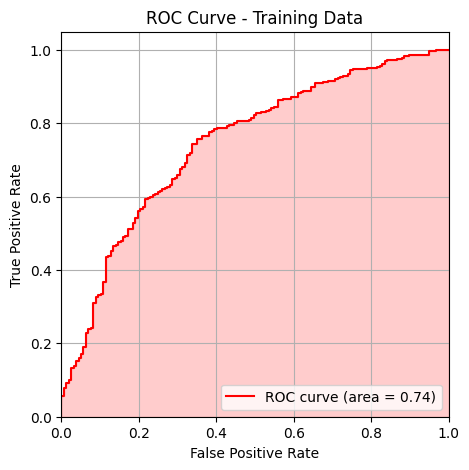

*****LogisticRegression*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              0.627907  0.343949  0.444444   157.00
1              0.751208  0.906706  0.821664   343.00
accuracy       0.730000  0.730000  0.730000     0.73
macro avg      0.689557  0.625327  0.633054   500.00
weighted avg   0.712491  0.730000  0.703217   500.00

Precision_mean: 0.8314504310054801

Recall_mean: 0.5764040432255023

F1-Score: 0.821664464993395

ROC_AUC: 0.7438116283820171

PR_AUC: 0.8506969222628129




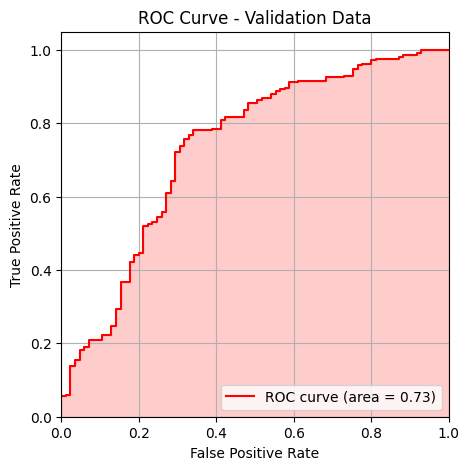

*****LogisticRegression*****
Stage: Validation
Classification Report:
              precision    recall  f1-score     support
0              0.617021  0.341176  0.439394   85.000000
1              0.778656  0.916279  0.841880  215.000000
accuracy       0.753333  0.753333  0.753333    0.753333
macro avg      0.697839  0.628728  0.640637  300.000000
weighted avg   0.732860  0.753333  0.727843  300.000000

Precision_mean: 0.8392080781450489

Recall_mean: 0.5659584331298771

F1-Score: 0.8418803418803419

ROC_AUC: 0.7335704514363884

PR_AUC: 0.8518407861845394




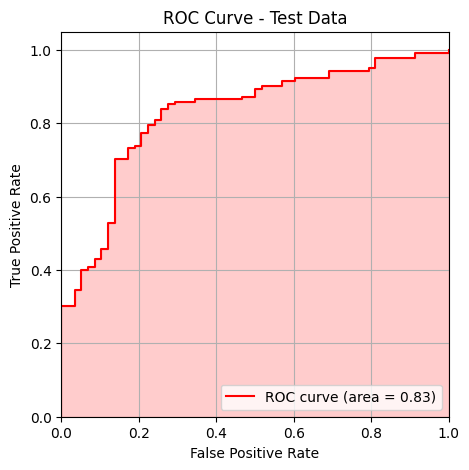

*****LogisticRegression*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.657895  0.431034  0.520833    58.00
1              0.796296  0.908451  0.848684   142.00
accuracy       0.770000  0.770000  0.770000     0.77
macro avg      0.727096  0.669743  0.684759   200.00
weighted avg   0.756160  0.770000  0.753607   200.00

Precision_mean: 0.8925628131136224

Recall_mean: 0.5945623992712493

F1-Score: 0.8486842105263158

ROC_AUC: 0.827707625060709

PR_AUC: 0.9215084183752063




In [433]:
ML(model[0],LR_param)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
***** DecisionTreeClassifier *****
Cross-validation accuracy (Training): 0.696
Grid Search Best Score : 0.7


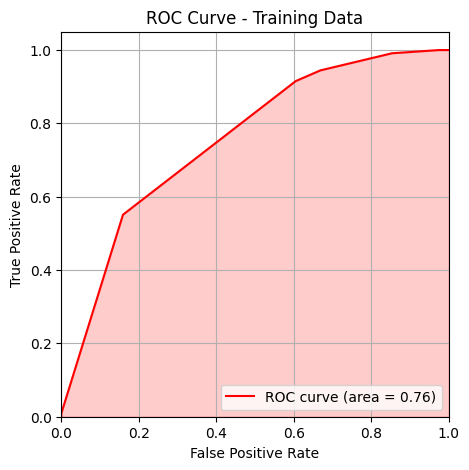

*****DecisionTreeClassifier*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              0.681319  0.394904  0.500000  157.000
1              0.767726  0.915452  0.835106  343.000
accuracy       0.752000  0.752000  0.752000    0.752
macro avg      0.724522  0.655178  0.667553  500.000
weighted avg   0.740594  0.752000  0.729883  500.000

Precision_mean: 0.8126225403538743

Recall_mean: 0.6763848396501457

F1-Score: 0.8351063829787234

ROC_AUC: 0.7554827208408387

PR_AUC: 0.8828730444279681




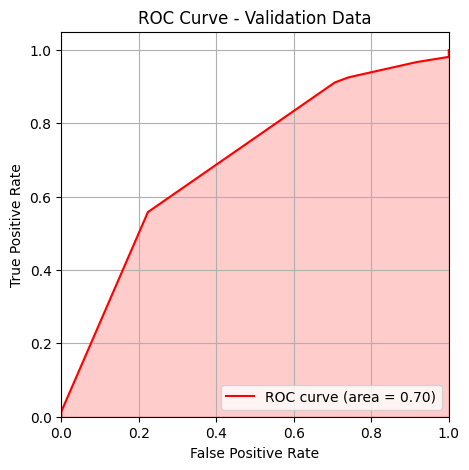

*****DecisionTreeClassifier*****
Stage: Validation
Classification Report:
              precision    recall  f1-score     support
0              0.568182  0.294118  0.387597   85.000000
1              0.765625  0.911628  0.832272  215.000000
accuracy       0.736667  0.736667  0.736667    0.736667
macro avg      0.666903  0.602873  0.609934  300.000000
weighted avg   0.709683  0.736667  0.706281  300.000000

Precision_mean: 0.8181566961285052

Recall_mean: 0.6697674418604651

F1-Score: 0.832271762208068

ROC_AUC: 0.6981121751025992

PR_AUC: 0.8739567165385335




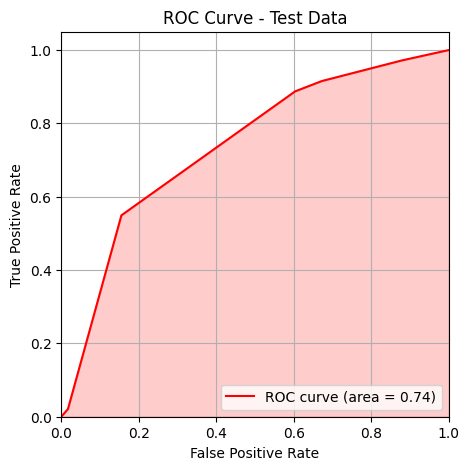

*****DecisionTreeClassifier*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.589744  0.396552  0.474227   58.000
1              0.782609  0.887324  0.831683  142.000
accuracy       0.745000  0.745000  0.745000    0.745
macro avg      0.686176  0.641938  0.652955  200.000
weighted avg   0.726678  0.745000  0.728021  200.000

Precision_mean: 0.8055071313113721

Recall_mean: 0.6207243460764588

F1-Score: 0.8316831683168316

ROC_AUC: 0.737918892666343

PR_AUC: 0.8214936205477203




In [434]:
ML(model[1],Tree_param)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
***** RandomForestClassifier *****
Cross-validation accuracy (Training): 0.718
Grid Search Best Score : 0.736


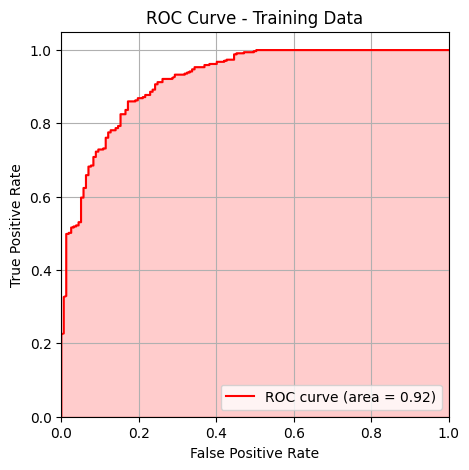

*****RandomForestClassifier*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              1.000000  0.420382  0.591928  157.000
1              0.790323  1.000000  0.882883  343.000
accuracy       0.818000  0.818000  0.818000    0.818
macro avg      0.895161  0.710191  0.737406  500.000
weighted avg   0.856161  0.818000  0.791523  500.000

Precision_mean: 0.9116985665843595

Recall_mean: 0.6450882307810342

F1-Score: 0.8828828828828829

ROC_AUC: 0.92006647973111

PR_AUC: 0.9582715849234508




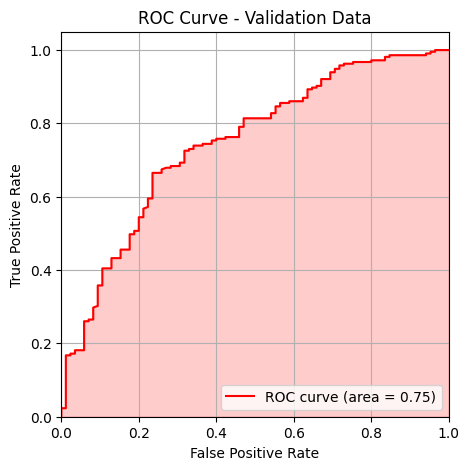

*****RandomForestClassifier*****
Stage: Validation
Classification Report:
              precision    recall  f1-score     support
0              0.750000  0.247059  0.371681   85.000000
1              0.764706  0.967442  0.854209  215.000000
accuracy       0.763333  0.763333  0.763333    0.763333
macro avg      0.757353  0.607250  0.612945  300.000000
weighted avg   0.760539  0.763333  0.717493  300.000000

Precision_mean: 0.8517083053963254

Recall_mean: 0.5740638549467875

F1-Score: 0.8542094455852156

ROC_AUC: 0.7458549931600548

PR_AUC: 0.8685719363720809




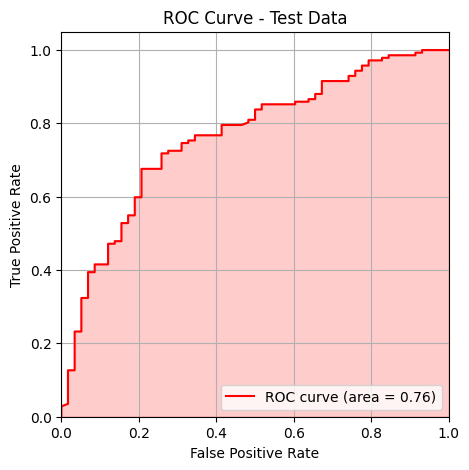

*****RandomForestClassifier*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.608696  0.241379  0.345679   58.000
1              0.751412  0.936620  0.833856  142.000
accuracy       0.735000  0.735000  0.735000    0.735
macro avg      0.680054  0.589000  0.589767  200.000
weighted avg   0.710025  0.735000  0.692285  200.000

Precision_mean: 0.8562714913257765

Recall_mean: 0.57981220657277

F1-Score: 0.8338557993730408

ROC_AUC: 0.76287032540068

PR_AUC: 0.8753850750674121




In [435]:
ML(model[2],RF_param)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
***** GradientBoostingClassifier *****
Cross-validation accuracy (Training): 0.726
Grid Search Best Score : 0.736


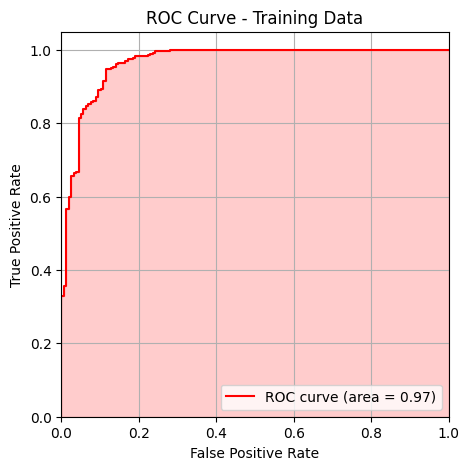

*****GradientBoostingClassifier*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              0.967742  0.764331  0.854093  157.000
1              0.901596  0.988338  0.942976  343.000
accuracy       0.918000  0.918000  0.918000    0.918
macro avg      0.934669  0.876335  0.898534  500.000
weighted avg   0.922366  0.918000  0.915067  500.000

Precision_mean: 0.9311495460828155

Recall_mean: 0.6466530612244898

F1-Score: 0.9429763560500696

ROC_AUC: 0.9664444485710573

PR_AUC: 0.9813118032707597




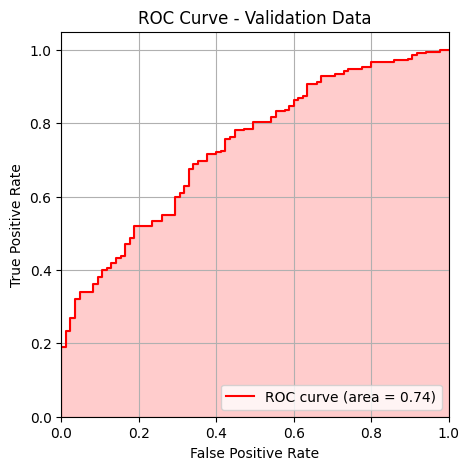

*****GradientBoostingClassifier*****
Stage: Validation
Classification Report:
              precision    recall  f1-score  support
0              0.533333  0.376471  0.441379    85.00
1              0.779167  0.869767  0.821978   215.00
accuracy       0.730000  0.730000  0.730000     0.73
macro avg      0.656250  0.623119  0.631679   300.00
weighted avg   0.709514  0.730000  0.714142   300.00

Precision_mean: 0.8604352704379096

Recall_mean: 0.5672558139534883

F1-Score: 0.8219780219780219

ROC_AUC: 0.7355403556771546

PR_AUC: 0.8801300055469877




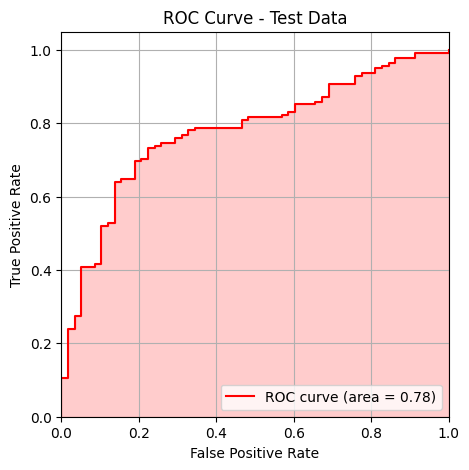

*****GradientBoostingClassifier*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.490196  0.431034  0.458716   58.000
1              0.778523  0.816901  0.797251  142.000
accuracy       0.705000  0.705000  0.705000    0.705
macro avg      0.634360  0.623968  0.627983  200.000
weighted avg   0.694909  0.705000  0.699076  200.000

Precision_mean: 0.8724828043853206

Recall_mean: 0.5800224230957888

F1-Score: 0.7972508591065293

ROC_AUC: 0.7773190869354054

PR_AUC: 0.8964327136558596




In [436]:
ML(model[3],GB_param)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
***** KNeighborsClassifier *****
Cross-validation accuracy (Training): 0.63
Grid Search Best Score : 0.63


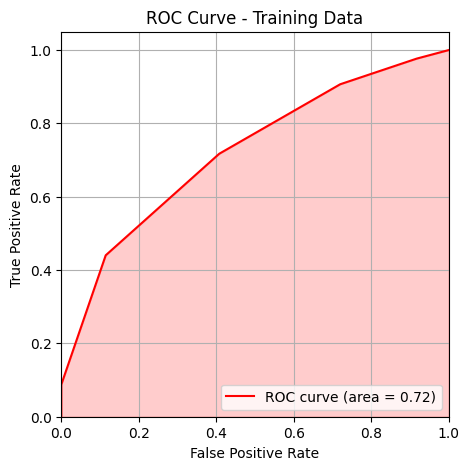

*****KNeighborsClassifier*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              0.578947  0.280255  0.377682   157.00
1              0.733491  0.906706  0.810952   343.00
accuracy       0.710000  0.710000  0.710000     0.71
macro avg      0.656219  0.593480  0.594317   500.00
weighted avg   0.684964  0.710000  0.674905   500.00

Precision_mean: 0.8294148246561708

Recall_mean: 0.5897542690545606

F1-Score: 0.8109517601043025

ROC_AUC: 0.7209986815472322

PR_AUC: 0.8660502090370634




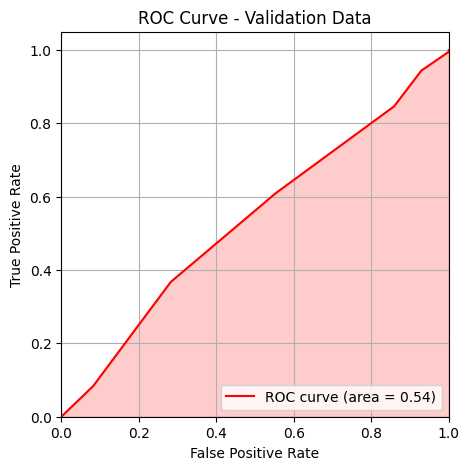

*****KNeighborsClassifier*****
Stage: Validation
Classification Report:
              precision    recall  f1-score     support
0              0.266667  0.141176  0.184615   85.000000
1              0.713725  0.846512  0.774468  215.000000
accuracy       0.646667  0.646667  0.646667    0.646667
macro avg      0.490196  0.493844  0.479542  300.000000
weighted avg   0.587059  0.646667  0.607343  300.000000

Precision_mean: 0.761114340484772

Recall_mean: 0.6058139534883721

F1-Score: 0.774468085106383

ROC_AUC: 0.5350205198358413

PR_AUC: 0.7467029428264468




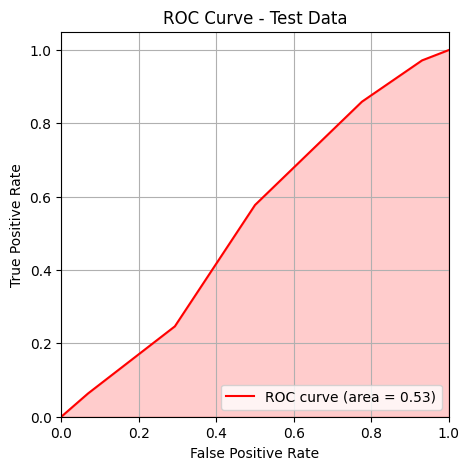

*****KNeighborsClassifier*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.393939  0.224138  0.285714   58.000
1              0.730539  0.859155  0.789644  142.000
accuracy       0.675000  0.675000  0.675000    0.675
macro avg      0.562239  0.541646  0.537679  200.000
weighted avg   0.632925  0.675000  0.643504  200.000

Precision_mean: 0.7519160394684347

Recall_mean: 0.5311871227364185

F1-Score: 0.7896440129449838

ROC_AUC: 0.5303545410393395

PR_AUC: 0.7209888539661036




In [437]:
ML(model[4],KNN_param)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
***** GaussianNB *****
Cross-validation accuracy (Training): 0.704
Grid Search Best Score : 0.704


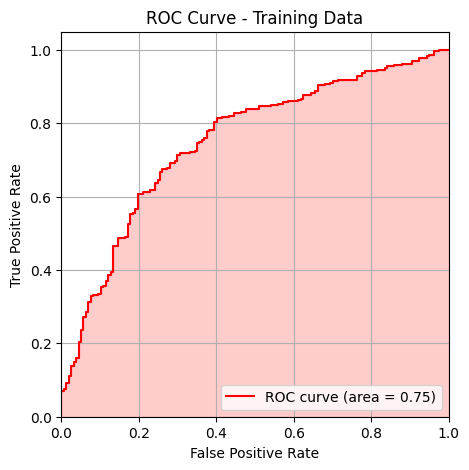

*****GaussianNB*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              0.581967  0.452229  0.508961  157.000
1              0.772487  0.851312  0.809986  343.000
accuracy       0.726000  0.726000  0.726000    0.726
macro avg      0.677227  0.651771  0.659473  500.000
weighted avg   0.712664  0.726000  0.715464  500.000

Precision_mean: 0.8369523887224026

Recall_mean: 0.5782080154559687

F1-Score: 0.8099861303744799

ROC_AUC: 0.7495682531429314

PR_AUC: 0.857930867902952




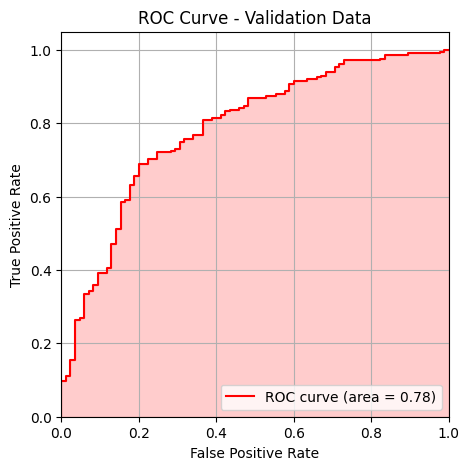

*****GaussianNB*****
Stage: Validation
Classification Report:
              precision    recall  f1-score     support
0              0.625000  0.411765  0.496454   85.000000
1              0.795082  0.902326  0.845316  215.000000
accuracy       0.763333  0.763333  0.763333    0.763333
macro avg      0.710041  0.657045  0.670885  300.000000
weighted avg   0.746892  0.763333  0.746472  300.000000

Precision_mean: 0.8719012164178762

Recall_mean: 0.5802982307038553

F1-Score: 0.8453159041394336

ROC_AUC: 0.7843502051983585

PR_AUC: 0.8923153839437945




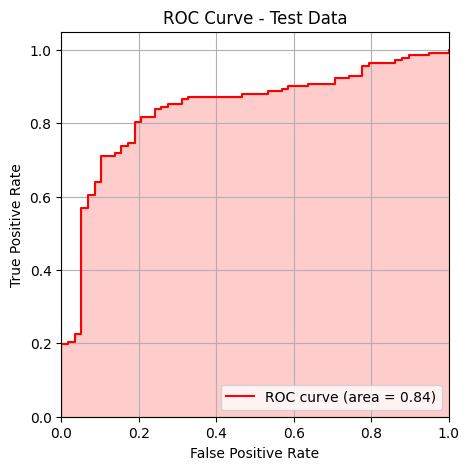

*****GaussianNB*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.666667  0.620690  0.642857     58.0
1              0.849315  0.873239  0.861111    142.0
accuracy       0.800000  0.800000  0.800000      0.8
macro avg      0.757991  0.746965  0.751984    200.0
weighted avg   0.796347  0.800000  0.797817    200.0

Precision_mean: 0.8956936176615226

Recall_mean: 0.5979258636395487

F1-Score: 0.8611111111111112

ROC_AUC: 0.8393637688198154

PR_AUC: 0.9255969045628338




In [438]:
ML(model[5],NB_param)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
***** XGBClassifier *****
Cross-validation accuracy (Training): 0.736
Grid Search Best Score : 0.736


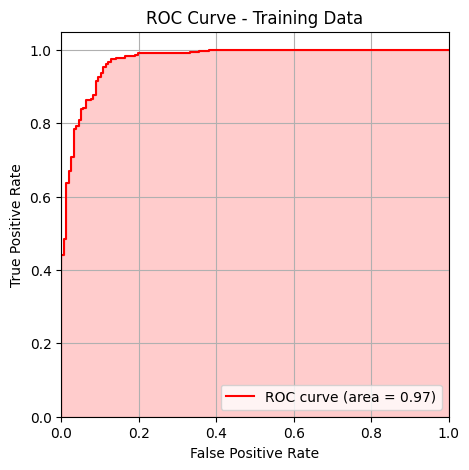

*****XGBClassifier*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              0.990099  0.636943  0.775194  157.000
1              0.857143  0.997085  0.921833  343.000
accuracy       0.884000  0.884000  0.884000    0.884
macro avg      0.923621  0.817014  0.848513  500.000
weighted avg   0.898891  0.884000  0.875788  500.000

Precision_mean: 0.9343570304200841

Recall_mean: 0.6481323068149416

F1-Score: 0.921832884097035

ROC_AUC: 0.9727024567788899

PR_AUC: 0.9857595841760449




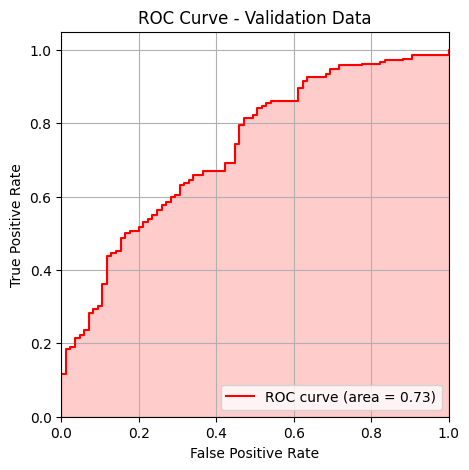

*****XGBClassifier*****
Stage: Validation
Classification Report:
              precision    recall  f1-score     support
0              0.627907  0.317647  0.421875   85.000000
1              0.774319  0.925581  0.843220  215.000000
accuracy       0.753333  0.753333  0.753333    0.753333
macro avg      0.701113  0.621614  0.632548  300.000000
weighted avg   0.732836  0.753333  0.723839  300.000000

Precision_mean: 0.8532597383573531

Recall_mean: 0.5653557907749363

F1-Score: 0.8432203389830508

ROC_AUC: 0.731436388508892

PR_AUC: 0.870242529575227




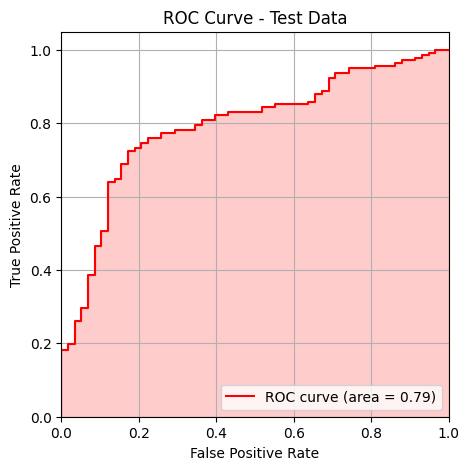

*****XGBClassifier*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.526316  0.344828  0.416667    58.00
1              0.765432  0.873239  0.815789   142.00
accuracy       0.720000  0.720000  0.720000     0.72
macro avg      0.645874  0.609034  0.616228   200.00
weighted avg   0.696088  0.720000  0.700044   200.00

Precision_mean: 0.8776729618429198

Recall_mean: 0.5873239436619718

F1-Score: 0.8157894736842105

ROC_AUC: 0.7935891209324915

PR_AUC: 0.9035576897408422




In [439]:
ML(model[6],XGB_param)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Number of positive: 343, number of negative: 157
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686000 -> initscore=0.781485
[LightGBM] [Info] Start training from score 0.781485
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current val

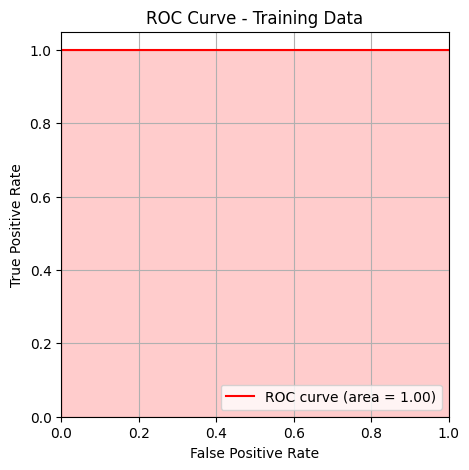

*****LGBMClassifier*****
Stage: Training
Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0    157.0
1                   1.0     1.0       1.0    343.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    500.0
weighted avg        1.0     1.0       1.0    500.0

Precision_mean: 0.9443356546940616

Recall_mean: 0.656686626746507

F1-Score: 1.0

ROC_AUC: 1.0

PR_AUC: 0.9999999999999999




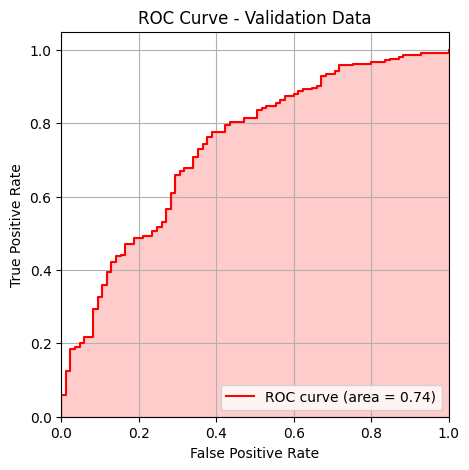

*****LGBMClassifier*****
Stage: Validation
Classification Report:
              precision    recall  f1-score  support
0              0.552239  0.435294  0.486842    85.00
1              0.793991  0.860465  0.825893   215.00
accuracy       0.740000  0.740000  0.740000     0.74
macro avg      0.673115  0.647880  0.656367   300.00
weighted avg   0.725495  0.740000  0.729828   300.00

Precision_mean: 0.8494691853745675

Recall_mean: 0.5663910994359885

F1-Score: 0.8258928571428571

ROC_AUC: 0.7351025991792066

PR_AUC: 0.8648390249064262




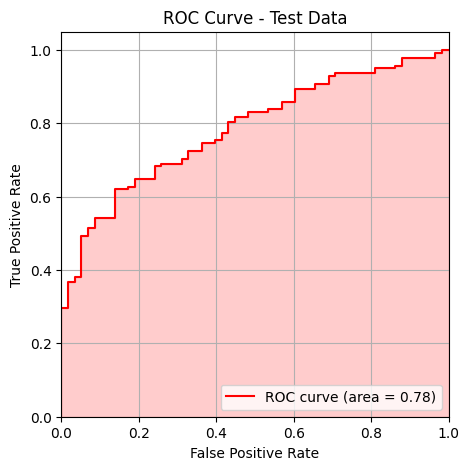

*****LGBMClassifier*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.555556  0.517241  0.535714    58.00
1              0.808219  0.830986  0.819444   142.00
accuracy       0.740000  0.740000  0.740000     0.74
macro avg      0.681887  0.674114  0.677579   200.00
weighted avg   0.734947  0.740000  0.737163   200.00

Precision_mean: 0.8816862812378943

Recall_mean: 0.5820194800644664

F1-Score: 0.8194444444444444

ROC_AUC: 0.7842399222923749

PR_AUC: 0.9091013164369139




In [440]:
ML(model[7],LGBM_param)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
***** ExtraTreeClassifier *****
Cross-validation accuracy (Training): 0.688
Grid Search Best Score : 0.682


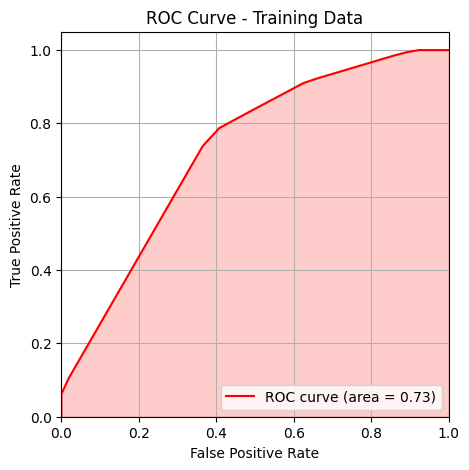

*****ExtraTreeClassifier*****
Stage: Training
Classification Report:
              precision    recall  f1-score  support
0              0.655556  0.375796  0.477733  157.000
1              0.760976  0.909621  0.828685  343.000
accuracy       0.742000  0.742000  0.742000    0.742
macro avg      0.708266  0.642709  0.653209  500.000
weighted avg   0.727874  0.742000  0.718486  500.000

Precision_mean: 0.8060548328463697

Recall_mean: 0.6979143305673918

F1-Score: 0.8286852589641435

ROC_AUC: 0.7269038643664928

PR_AUC: 0.855569394964974




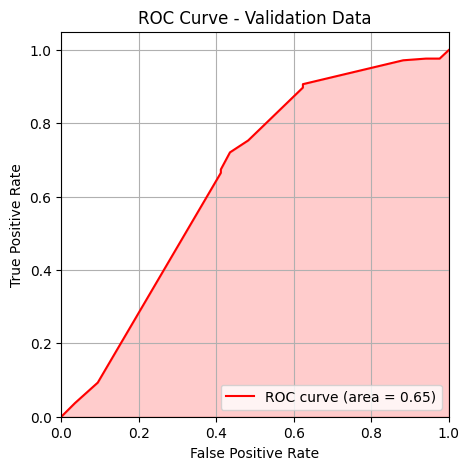

*****ExtraTreeClassifier*****
Stage: Validation
Classification Report:
              precision    recall  f1-score  support
0              0.592593  0.376471  0.460432    85.00
1              0.784553  0.897674  0.837310   215.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.688573  0.637073  0.648871   300.00
weighted avg   0.730164  0.750000  0.730528   300.00

Precision_mean: 0.778468678092601

Recall_mean: 0.6672629695885509

F1-Score: 0.8373101952277657

ROC_AUC: 0.65077975376197

PR_AUC: 0.7686321695610365




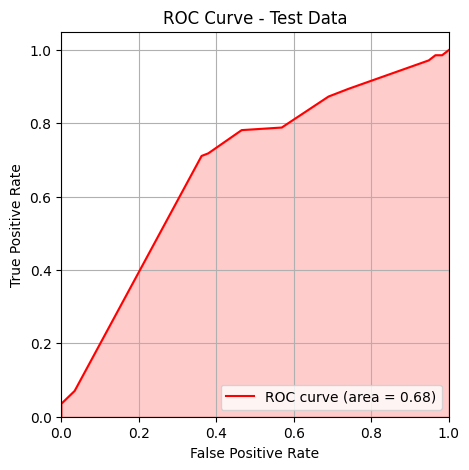

*****ExtraTreeClassifier*****
Stage: Test
Classification Report:
              precision    recall  f1-score  support
0              0.500000  0.310345  0.382979    58.00
1              0.756098  0.873239  0.810458   142.00
accuracy       0.710000  0.710000  0.710000     0.71
macro avg      0.628049  0.591792  0.596718   200.00
weighted avg   0.681829  0.710000  0.686489   200.00

Precision_mean: 0.8010517195498222

Recall_mean: 0.6782231852654388

F1-Score: 0.8104575163398693

ROC_AUC: 0.6781204468188441

PR_AUC: 0.8198595542471593




In [441]:
ML(model[8],Tree_param)

In [442]:
lst = ['train','test','val','representative']

for i in lst : 
    source = [item for sublist in globals()[f'{i}_score'] for item in sublist]
    globals()[f'{i}_bar'] = pd.DataFrame(source)

print(train_bar)
print(test_bar)
print(val_bar)
print(representative_bar)

   ROC_AUC_train  PR_AUC_train  Recall_train  Precision_train  F1-score_train  \
0       0.743812      0.850697      0.576404         0.831450        0.821664   
1       0.755483      0.882873      0.676385         0.812623        0.835106   
2       0.920066      0.958272      0.645088         0.911699        0.882883   
3       0.966444      0.981312      0.646653         0.931150        0.942976   
4       0.720999      0.866050      0.589754         0.829415        0.810952   
5       0.749568      0.857931      0.578208         0.836952        0.809986   
6       0.972702      0.985760      0.648132         0.934357        0.921833   
7       1.000000      1.000000      0.656687         0.944336        1.000000   
8       0.726904      0.855569      0.697914         0.806055        0.828685   

                        Model  
0          LogisticRegression  
1      DecisionTreeClassifier  
2      RandomForestClassifier  
3  GradientBoostingClassifier  
4        KNeighborsClassifier

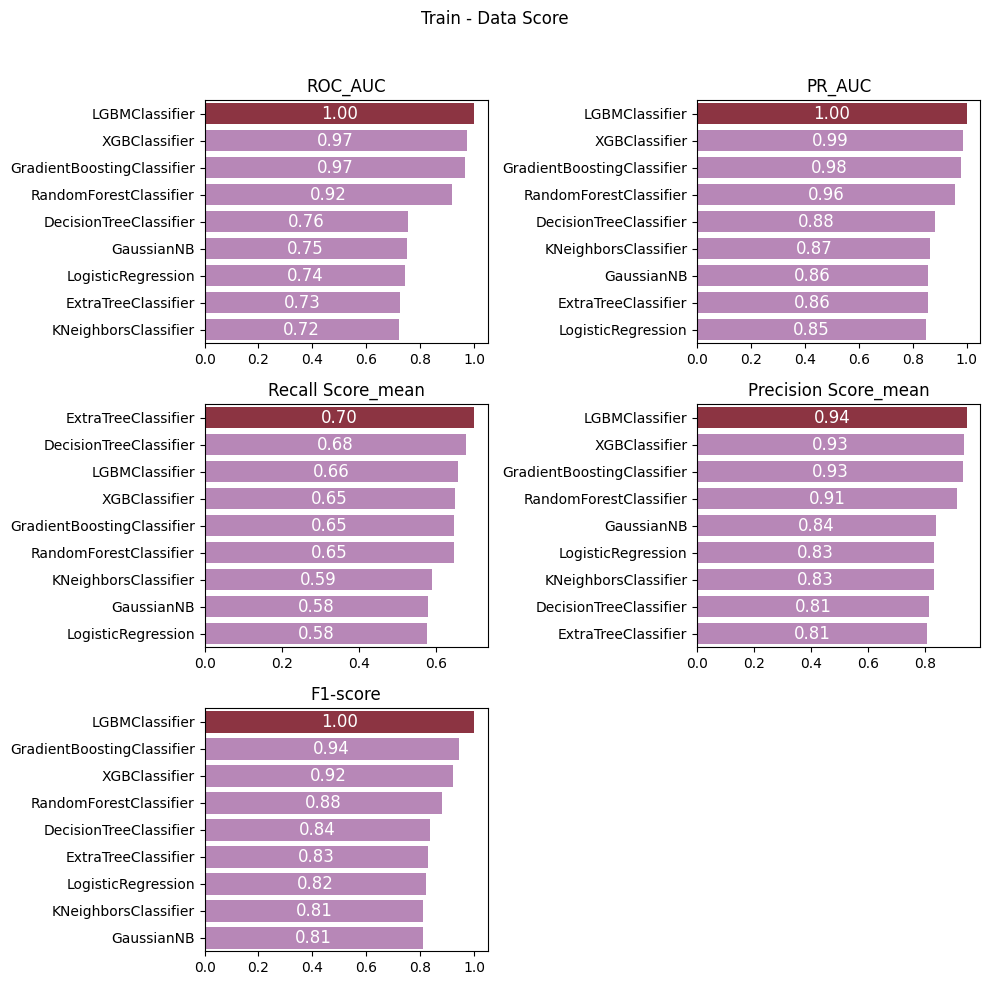

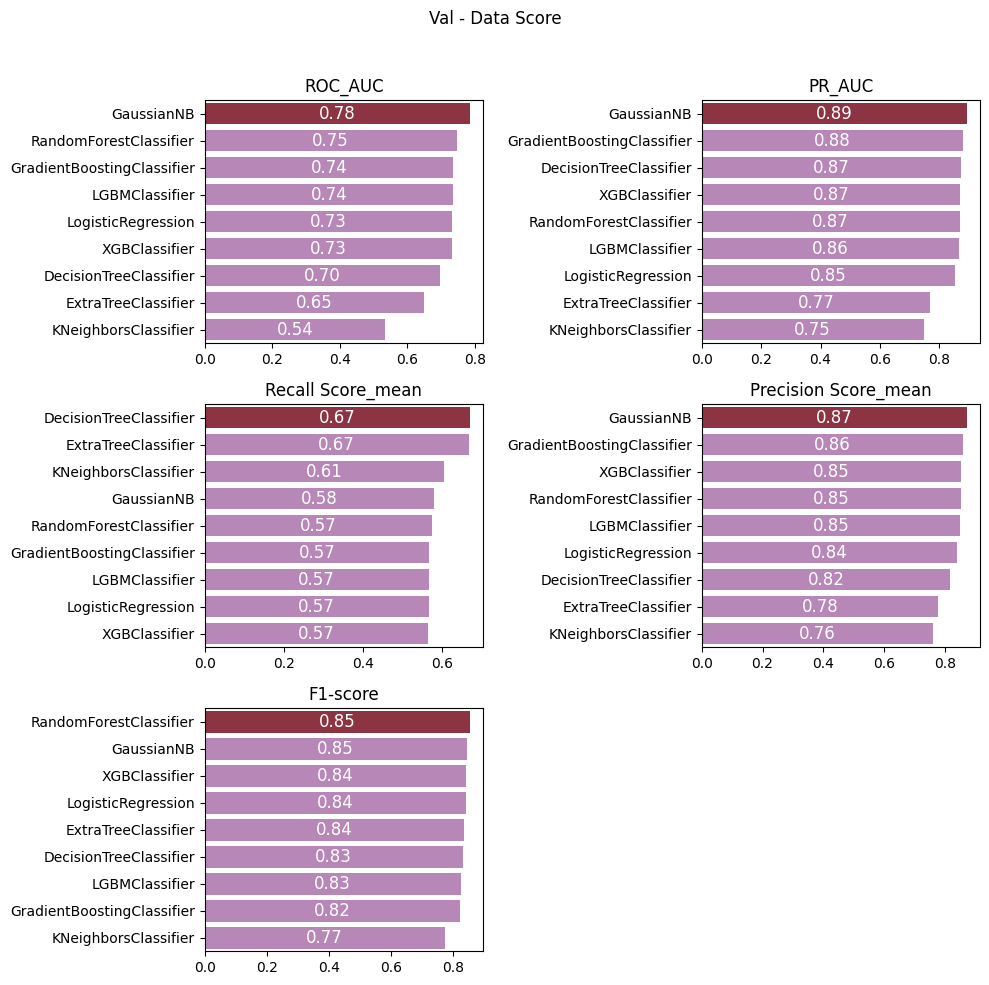

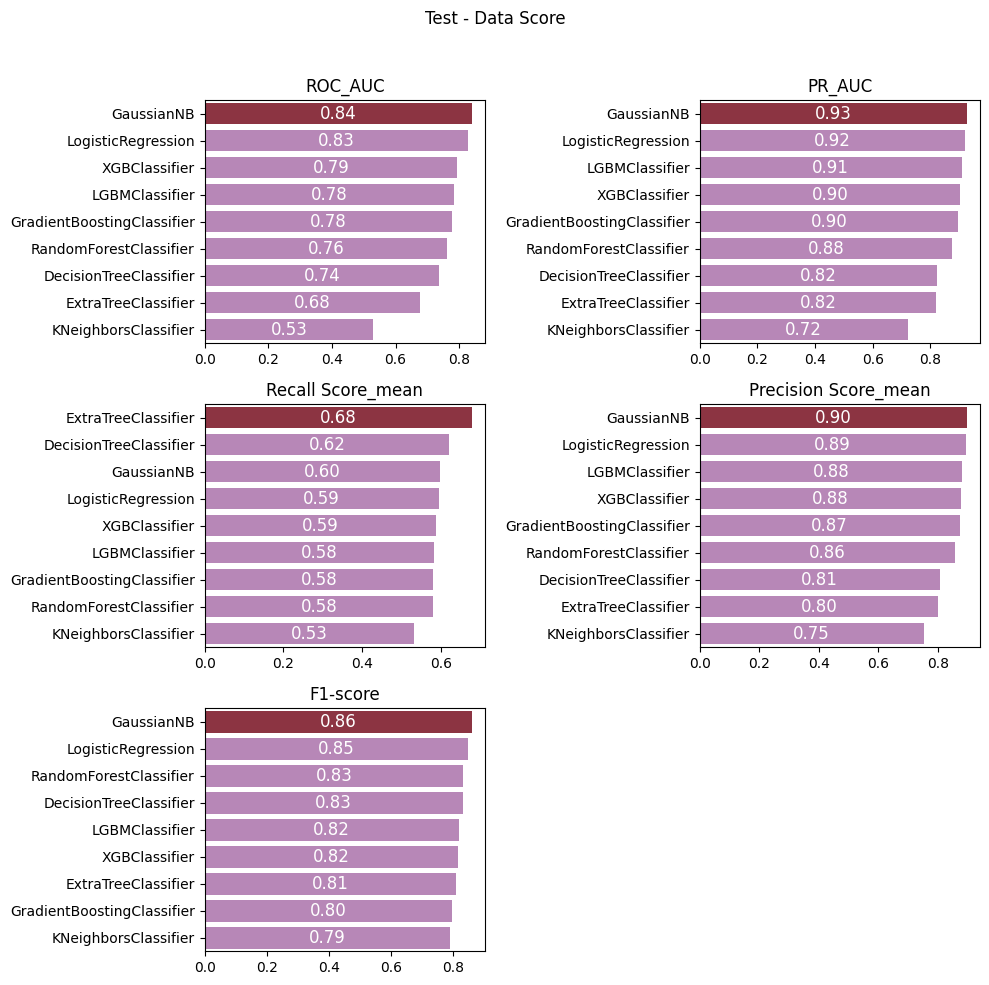

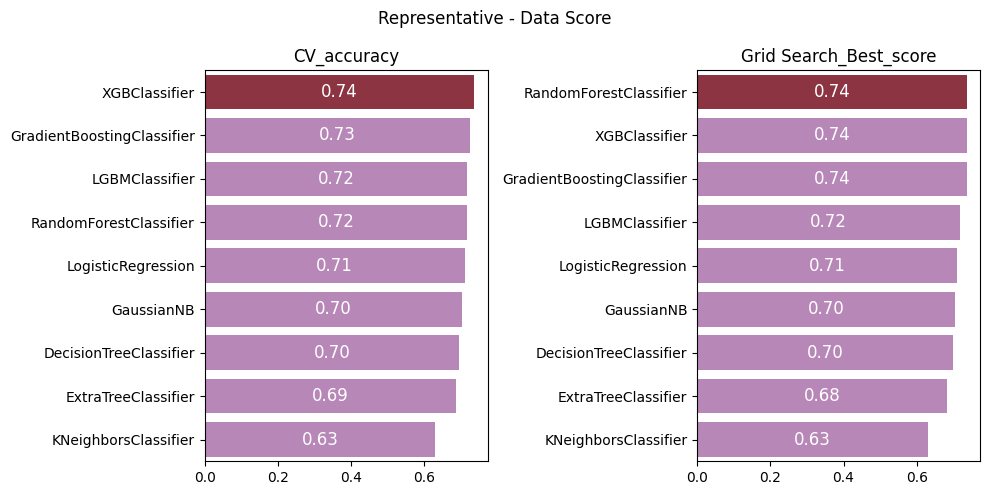

In [454]:
graph_lst = ['train', 'val', 'test']

for i in graph_lst:  
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))

    sns.barplot(data=globals()[f'{i}_bar'].sort_values(f'ROC_AUC_{i}', ascending=False),
                x=f'ROC_AUC_{i}', y='Model', color='purple', alpha=0.5, ax=axes[0, 0])
    
    top_roc_auc = globals()[f'{i}_bar'].sort_values(f'ROC_AUC_{i}', ascending=False).head(1)
    sns.barplot(data=top_roc_auc, 
                x=f'ROC_AUC_{i}', y='Model', color='darkred',alpha=0.7, ax=axes[0, 0])

    axes[0, 0].bar_label(axes[0, 0].containers[0], fmt='%.2f', label_type='center', color='white', fontsize=12)    
    axes[0, 0].set_title('ROC_AUC')
    axes[0, 0].set_ylabel('')
    axes[0, 0].set_xlabel('')

    sns.barplot(data=globals()[f'{i}_bar'].sort_values(f'PR_AUC_{i}', ascending=False),
                x=f'PR_AUC_{i}', y='Model', color='purple', alpha=0.5, ax=axes[0, 1])
    
    top_pr_auc = globals()[f'{i}_bar'].sort_values(f'PR_AUC_{i}', ascending=False).head(1)
    sns.barplot(data=top_pr_auc, 
                x=f'PR_AUC_{i}', y='Model', color='darkred',alpha=0.7, ax=axes[0, 1])
    
    
    axes[0, 1].bar_label(axes[0, 1].containers[0], fmt='%.2f', label_type='center', color='white', fontsize=12)    
    axes[0, 1].set_title('PR_AUC')
    axes[0, 1].set_ylabel('')
    axes[0, 1].set_xlabel('')

    sns.barplot(data=globals()[f'{i}_bar'].sort_values(f'Recall_{i}', ascending=False),
                x=f'Recall_{i}', y='Model', color='purple', alpha=0.5, ax=axes[1, 0])
    
    top_recall = globals()[f'{i}_bar'].sort_values(f'Recall_{i}', ascending=False).head(1)
    sns.barplot(data=top_recall, 
                x=f'Recall_{i}', y='Model', color='darkred',alpha=0.7, ax=axes[1, 0])
    
    axes[1, 0].bar_label(axes[1, 0].containers[0], fmt='%.2f', label_type='center', color='white', fontsize=12)    
    axes[1, 0].set_title('Recall Score_mean')
    axes[1, 0].set_ylabel('')
    axes[1, 0].set_xlabel('')

    sns.barplot(data=globals()[f'{i}_bar'].sort_values(f'Precision_{i}', ascending=False),
                x=f'Precision_{i}', y='Model', color='purple', alpha=0.5, ax=axes[1, 1])
    
    top_pre = globals()[f'{i}_bar'].sort_values(f'Precision_{i}', ascending=False).head(1)
    sns.barplot(data=top_pre, 
                x=f'Precision_{i}', y='Model', color='darkred',alpha=0.7, ax=axes[1, 1])
    
    axes[1, 1].bar_label(axes[1, 1].containers[0], fmt='%.2f', label_type='center', color='white', fontsize=12)    
    axes[1, 1].set_title('Precision Score_mean')
    axes[1, 1].set_ylabel('')
    axes[1, 1].set_xlabel('')

    sns.barplot(data=globals()[f'{i}_bar'].sort_values(f'F1-score_{i}', ascending=False),
                x=f'F1-score_{i}', y='Model', color='purple', alpha=0.5, ax=axes[2, 0])
    
    top_f1 = globals()[f'{i}_bar'].sort_values(f'F1-score_{i}', ascending=False).head(1)
    sns.barplot(data=top_f1, 
                x=f'F1-score_{i}', y='Model', color='darkred',alpha=0.7, ax=axes[2, 0])
    axes[2, 0].bar_label(axes[2, 0].containers[0], fmt='%.2f', label_type='center', color='white', fontsize=12)    
    axes[2, 0].set_title('F1-score')
    axes[2, 0].set_ylabel('')
    axes[2, 0].set_xlabel('')

    fig.delaxes(axes[2, 1])

    fig.suptitle(f'{i.capitalize()} - Data Score')

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data=representative_bar.sort_values('CV_score', ascending=False),
            x='CV_score', y='Model', color='purple', alpha=0.5, ax=axes[0])

sns.barplot(data =representative_bar.sort_values('CV_score',ascending=False).head(1), 
            x = 'CV_score', y= 'Model', color = 'darkred', alpha = .7, ax = axes[0])

axes[0].bar_label(axes[0].containers[0], fmt='%.2f', label_type = 'center', color = 'white', fontsize = 12)
axes[0].set_title('CV_accuracy')
axes[0].set_ylabel('')
axes[0].set_xlabel('')

sns.barplot(data=representative_bar.sort_values('Best_score', ascending=False),
            x='Best_score', y='Model', color='purple', alpha=0.5, ax=axes[1])

sns.barplot(data=representative_bar.sort_values('Best_score',ascending=False).head(1), 
            x = 'Best_score', y= 'Model', color = 'darkred', alpha = .7, ax = axes[1])

axes[1].bar_label(axes[1].containers[0], fmt='%.2f', label_type = 'center', color = 'white', fontsize = 12)
axes[1].set_title('Grid Search_Best_score')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
fig.suptitle('Representative - Data Score')
plt.tight_layout()
plt.show()


- 분류 모델 활용하여 대출심사

In [18]:
X = credit.drop('Creditability', axis=1, inplace=False)
y = credit.Creditability
    
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.625, random_state=42)

In [27]:
Tree = model[1]

In [28]:
grid_search = GridSearchCV(Tree, Tree_param, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [46]:
# Tree.fit(X_train,y_train)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10]}, scoring='accuracy',
             verbose=1)

In [47]:
y_predict = Tree.predict(X_test)

In [48]:
coef = pd.Series(data=np.round(Tree.feature_importances_, 2), index=X.columns)
print(coef.index)


Index(['Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount($)',
       'Length of current employment(Month)', 'Sex & Marital Status',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Type of apartment', 'No of Credits at this Bank',
       'Occupation', 'No of dependents', 'Telephone', 'Foreign Worker'],
      dtype='object')


In [67]:
def credit() : 
    print('대출심사 - - 조건에 해당하는 정보를 입력해주십시오.')
    print('**** 아래 보기를 확인하여 작성해주세요 ****\n')
    Account_Balance = int(input('은행잔고 : '))
    Duration_of_Credit_month = int(input('대출기간 : '))
    Payment_Status_of_Previous_Credit = int(input('대출납입상태 : '))
    Purpose = int(input('대출목적 : '))
    Credit_Amount = int(input('대출액 : '))
    Length_of_current_employment = int(input('현 직업 근무 기간 : '))
    Sex_Marital_Status = int(input('성별 : '))
    Duration_in_Current_address = int(input('현 거주지 거주기간 : '))
    Most_valuable_available_asset = int(input('가장 가치있는 자산 : '))
    Age = int(input('나이 : '))
    Type_of_apartment = int(input('주거환경 : '))
    No_of_Credits_at_this_Bank = int(input('대출 건수 : '))
    Occupation = int(input('직업 : '))
    No_of_dependents = int(input('부양 가족 수 : '))
    Telephone = int(input('전화기 소유 여부 : '))
    Foreign_Worker = int(input('외국인 근로자 여부 : '))

    credit_classifier = Tree.predict([[Account_Balance,Duration_of_Credit_month,Payment_Status_of_Previous_Credit,Purpose,Credit_Amount,Length_of_current_employment,Sex_Marital_Status,Duration_in_Current_address,Most_valuable_available_asset,Age,Type_of_apartment,No_of_Credits_at_this_Bank,Occupation,No_of_dependents,Telephone,Foreign_Worker]])

    print('은행잔고 : ',Account_Balance)
    print('대출기간 : ',Duration_of_Credit_month)
    print('대출 납입 상태 : ',Payment_Status_of_Previous_Credit)
    print('대출목적 : ',Purpose)
    print('대출액 : ' ,Credit_Amount)
    print('현 직업 근무 기간 : ',Length_of_current_employment)
    print('성별 : ',Sex_Marital_Status)
    print('현 거주지 거주기간 : ',Duration_in_Current_address)
    print('가장 가치있는 자산 : ',Most_valuable_available_asset)
    print('나이 : ',Age)
    print('주거환경 : ',Type_of_apartment)
    print('대출 건수 : ',No_of_Credits_at_this_Bank)
    print('직업 : ',Occupation)
    print('부양 가족 수 : ',No_of_dependents)
    print('전화기 소유 여부 : ',Telephone)
    print('외국인 근로자 여부 : ',Foreign_Worker)

    if credit_classifier == 1 : 
        print('\n대출조건이 적합합니다. \n은행에 방문해주세요.')
    else : 
        print('\n다음기회에')

In [69]:
credit()

대출심사 - - 조건에 해당하는 정보를 입력해주십시오.
**** 아래 보기를 확인하여 작성해주세요 ****

은행잔고 :  2
대출기간 :  12
대출 납입 상태 :  1
대출목적 :  1
대출액 :  4000000
현 직업 근무 기간 :  2
성별 :  2
현 거주지 거주기간 :  2
가장 가치있는 자산 :  1
나이 :  44
주거환경 :  1
대출 건수 :  2
직업 :  3
부양 가족 수 :  1
전화기 소유 여부 :  2
외국인 근로자 여부 :  1

다음기회에


-은행잔고
1: No account
2 : None (No balance)
3 : Some Balance

-대출기간
Free

-대출납입 상태
0 : Delayed
1 : Other Credits
2 : Paid Up
3 : No Problem with Current Credits
4 : Previous Credits Paid

-대출목적 
1 : New Car 
2 : Used Car 
3 : Furniture 
4 : TV 
5 : Appliances 
6 : Repair 
8 : Vacation 
9 :Retraining 
10 : Business 
0 : Other

-대출액
Free

-현 직업 근무기간
1: Unemployed
2: <1 Year
3: [1, 4)
4: [4, 7)
5: Above 7


-성별
1: Male, Divorced
2: Male, Single 
3: Male, Married/Widowed 
4: Female

-현 거주지 거주기간
1: <1 Year 
2: [1, 4) 
3: [4, 7) 
4: Above 7

-가장 가치있는 자산
1: None 
2: Car 
3: Life Insurance 
4: Real Estate

-나이
Free

-주거환경
1: free apartment
2: Rented
3: Owned

-대출건수
1 : one
2 : 2~3
3 : 4~5
4 : 6 ~

-직업
1: Unemployed, unskilled
2: Unskilled Permanent Resident
3: Skilled
4: Executive

-부양 가족 수 
Free

-핸드폰 소지 여부
2: Yes 
1: No

-외국인 근로자 여부
2: Yes 
1: No